## Driver_drowsiness_detection

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled pr

In [1]:
!pip install optuna

  Using cached optuna-4.6.0-py3-none-any.whl.metadata (17 kB)
  Using cached colorlog-6.10.1-py3-none-any.whl.metadata (11 kB)
Using cached optuna-4.6.0-py3-none-any.whl (404 kB)
Using cached colorlog-6.10.1-py3-none-any.whl (11 kB)


## UTA preprocessing

In [2]:
import os
import re
import math
import copy
import random
from pathlib import Path
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
import optuna
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torchvision.transforms as T
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Global seed set to: {SEED}")

Global seed set to: 42


## UTA preprocessing

In [8]:
IN_DIR = Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_frames_all_processed/frames_aligned")
OUT_DIR = Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224")
DEBUG_DIR = OUT_DIR / "debug"

In [9]:
OUTPUT_SIZE = 224
MARGIN = 0.20
MAX_DEBUG = 10

In [10]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

# Helpers

In [11]:
def expand_box(x1, y1, x2, y2, w, h, margin):
    bw, bh = x2 - x1, y2 - y1
    ex, ey = int(bw * margin), int(bh * margin)

    x1n = max(0, x1 - ex)
    y1n = max(0, y1 - ey)
    x2n = min(w, x2 + ex)
    y2n = min(h, y2 + ey)

    return x1n, y1n, x2n, y2n


def make_square(x1, y1, x2, y2, w, h):
    bw, bh = x2 - x1, y2 - y1
    side = max(bw, bh)

    cx = x1 + bw // 2
    cy = y1 + bh // 2
    half = side // 2

    sx1 = max(0, cx - half)
    sy1 = max(0, cy - half)
    sx2 = min(w, sx1 + side)
    sy2 = min(h, sy1 + side)


    sx1 = max(0, min(sx1, w - side))
    sy1 = max(0, min(sy1, h - side))

    return int(sx1), int(sy1), int(sx1 + side), int(sy1 + side)


def fallback_center(w, h, frac=0.6):
    side = int(min(w, h) * frac)
    cx, cy = w // 2, h // 2
    return cx - side//2, cy - side//2, cx + side//2, cy + side//2


# Main preprocessing

In [12]:
mp_fd = mp.solutions.face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.4)

all_images = sorted([p for p in IN_DIR.rglob("*") if p.suffix.lower() in [".jpg", ".png"]])
print("Total images found:", len(all_images))

records = []
debug_count = 0

for img_path in tqdm(all_images, desc="Cropping faces"):
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = mp_fd.process(rgb)

    if result.detections:
        det = result.detections[0]
        box = det.location_data.relative_bounding_box

        x1 = int(box.xmin * w)
        y1 = int(box.ymin * h)
        x2 = int((box.xmin + box.width) * w)
        y2 = int((box.ymin + box.height) * h)

        x1, y1, x2, y2 = expand_box(x1, y1, x2, y2, w, h, MARGIN)
        x1, y1, x2, y2 = make_square(x1, y1, x2, y2, w, h)

        method = "mp_face"
    else:
        x1, y1, x2, y2 = fallback_center(w, h, frac=0.5)
        method = "fallback"

    crop = img[y1:y2, x1:x2]
    crop = cv2.resize(crop, (OUTPUT_SIZE, OUTPUT_SIZE))

    rel = img_path.relative_to(IN_DIR)
    out_file = (OUT_DIR / rel.parent / (img_path.stem + "_face.jpg"))
    out_file.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_file), crop)


    records.append({
        "src": str(img_path),
        "dst": str(out_file),
        "method": method,
        "bbox": (x1, y1, x2, y2)
    })


    if debug_count < MAX_DEBUG:
        preview = np.hstack([cv2.resize(img, (300,300)), cv2.resize(crop, (300,300))])
        cv2.imwrite(str(DEBUG_DIR / f"debug_{debug_count}.jpg"), preview)
        debug_count += 1


Total images found: 2960


Cropping faces: 100%|██████████| 2960/2960 [01:56<00:00, 25.34it/s]


# CSV File generating for UTA

In [4]:
UTA_ROOT = Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224")

OUT_CSV = UTA_ROOT.parent / "processed" / "uta_final_meta.csv"
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

rows = []

for subject_dir in sorted(UTA_ROOT.iterdir()):
    if not subject_dir.is_dir():
        continue

    for intensity_dir in sorted(subject_dir.iterdir()):
        if not intensity_dir.is_dir():
            continue

        inten_name = intensity_dir.name.lower()

        if inten_name.startswith("0"):
            label = 0
            label_name = "alert"
        elif inten_name.startswith("5"):
            label = 1
            label_name = "low_drowsy"
        elif inten_name.startswith("10"):
            label = 2
            label_name = "high_drowsy"
        else:
            print("Skipping not intensity folders", intensity_dir)
            continue

        video_id = f"{subject_dir.name}_{intensity_dir.name}"

        for img_path in sorted(intensity_dir.glob("*.jpg")):
            stem = img_path.stem
            m = re.search(r"_f(\d+)", stem)
            frame_idx = int(m.group(1)) if m else None

            rows.append({
                "img_path": str(img_path),
                "label": label,
                "label_name": label_name,
                "subject": subject_dir.name,
                "intensity_folder": intensity_dir.name,
                "frame_idx": frame_idx,
                "video_id": video_id
            })

uta_video = pd.DataFrame(rows)
uta_video.to_csv(OUT_CSV, index=False)

✅ UTA final meta CSV saved at: /content/drive/MyDrive/driver_drowsiness_detection/processed/uta_final_meta.csv
Total frames: 2951

Label counts (0=alert,1=low,2=high):
label
2    1037
0     958
1     956
Name: count, dtype: int64

Unique videos: 37


,img_path,label,label_name,subject,intensity_folder,frame_idx,video_id
0,/content/drive/MyDrive/driver_drowsiness_detec...,0,alert,Fold3_part1_25,0,222,Fold3_part1_25_0
1,/content/drive/MyDrive/driver_drowsiness_detec...,0,alert,Fold3_part1_25,0,444,Fold3_part1_25_0
2,/content/drive/MyDrive/driver_drowsiness_detec...,0,alert,Fold3_part1_25,0,666,Fold3_part1_25_0
3,/content/drive/MyDrive/driver_drowsiness_detec...,0,alert,Fold3_part1_25,0,888,Fold3_part1_25_0
4,/content/drive/MyDrive/driver_drowsiness_detec...,0,alert,Fold3_part1_25,0,1110,Fold3_part1_25_0


In [ ]:
print("UTA final meta CSV saved at:", OUT_CSV)
print("Total frames:", len(uta_video))
print("\nLabel counts (0=alert,1=low,2=high):")
print(uta_video["label"].value_counts())
print("\nUnique videos:", uta_video["video_id"].nunique())
uta_video.head()

## CEW Preprocessing**

In [40]:
CEW_ROOT = Path("/content/drive/MyDrive/driver_drowsiness_detection/CEW")
OUT_DIR = Path("/content/drive/MyDrive/driver_drowsiness_detection/CEW_processed_112")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OPEN_DIR = CEW_ROOT / "dataset_B_FacialImages" / "OpenFace"
CLOSED_DIR = CEW_ROOT / "dataset_B_FacialImages" / "ClosedFace"

IMG_SIZE = 112

In [41]:
mp_mesh = mp.solutions.face_mesh

def rotate_image(img, angle):
    h,w = img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, M, (w,h), borderMode=cv2.BORDER_REPLICATE)

def angle(p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    return math.degrees(math.atan2(dy, dx))

def crop_face(img, lm):
    h,w = img.shape[:2]
    xs = [p.x*w for p in lm]
    ys = [p.y*h for p in lm]
    min_x, max_x = int(min(xs))-20, int(max(xs))+20
    min_y, max_y = int(min(ys))-20, int(max(ys))+20
    min_x, min_y = max(0, min_x), max(0, min_y)
    max_x, max_y = min(w, max_x), min(h, max_y)
    crop = img[min_y:max_y, min_x:max_x]
    if crop.size == 0:
        return None
    return cv2.resize(crop, (IMG_SIZE, IMG_SIZE))

In [42]:
def process_cew_folder(folder, label_name):
    out_label = OUT_DIR / label_name
    out_label.mkdir(parents=True, exist_ok=True)

    images = list(folder.glob("*.jpg"))
    print(f"processing {label_name} ({len(images)} images)")

    with mp_mesh.FaceMesh(static_image_mode=True,
                          max_num_faces=1,
                          refine_landmarks=True) as fm:

        for img_path in tqdm(images):
            img = cv2.imread(str(img_path))
            if img is None:
                continue

            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            res = fm.process(rgb)

            if not res.multi_face_landmarks:
                continue

            lm = res.multi_face_landmarks[0].landmark

            left = np.mean([[lm[i].x, lm[i].y] for i in [33,133,159,145]], axis=0)
            right = np.mean([[lm[i].x, lm[i].y] for i in [362,263,386,374]], axis=0)
            left = (left[0]*img.shape[1], left[1]*img.shape[0])
            right = (right[0]*img.shape[1], right[1]*img.shape[0])

            ang = angle(left, right)
            aligned = rotate_image(img, -ang)

            rgb2 = cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)
            res2 = fm.process(rgb2)
            if not res2.multi_face_landmarks:
                continue

            crop = crop_face(aligned, res2.multi_face_landmarks[0].landmark)
            if crop is None:
                continue

            cv2.imwrite(str(out_label / img_path.name), crop)

In [43]:
process_cew_folder(OPEN_DIR, "open")
process_cew_folder(CLOSED_DIR, "closed")

Processing open (1231 images)


100%|██████████| 1231/1231 [01:01<00:00, 20.04it/s]


Processing closed (1192 images)


100%|██████████| 1192/1192 [00:56<00:00, 20.98it/s]

CEW preprocessing complete!


In [35]:
CROPPED_CEW_ROOT = Path("/content/drive/MyDrive/driver_drowsiness_detection/CEW_processed_112")

print("CEW cropped root exists:", CROPPED_CEW_ROOT.exists())
print("Subfolders:", [p.name for p in CROPPED_CEW_ROOT.iterdir() if p.is_dir()])

rows = []
for sub in sorted(CROPPED_CEW_ROOT.iterdir()):
    if not sub.is_dir():
        continue

    name_lower = sub.name.lower()
    if "open" in name_lower:
        label = 0
        label_name = "open"
    elif "close" in name_lower:
        label = 1
        label_name = "closed"
    else:
        print("unknown CEW folder (not open/closed):", sub)
        continue

    for img_path in sorted(sub.glob("*.jpg")):
        stem = img_path.stem
        rows.append({
            "img_path": str(img_path),
            "label": label,
            "label_name": label_name,
            "video_id": stem
        })

cew_head = pd.DataFrame(rows)
OUT_CEW_CSV = CROPPED_CEW_ROOT.parent / "processed" / "cew_final_meta.csv"
OUT_CEW_CSV.parent.mkdir(parents=True, exist_ok=True)
cew_head.to_csv(OUT_CEW_CSV, index=False)

print("\n CEW final meta CSV saved at:", OUT_CEW_CSV)
print("Total CEW images:", len(cew_head))
print("Label counts:\n", cew_head["label"].value_counts())

CEW cropped root exists: True
Subfolders: ['open', 'closed']

 CEW final meta CSV saved at: /content/drive/MyDrive/driver_drowsiness_detection/processed/cew_final_meta.csv
Total CEW images: 2381
Label counts:
 label
0    1224
1    1157
Name: count, dtype: int64


In [36]:
cew_head.head()

,img_path,label,label_name,video_id
0,/content/drive/MyDrive/driver_drowsiness_detec...,1,closed,closed_eye_0001.jpg_face_1
1,/content/drive/MyDrive/driver_drowsiness_detec...,1,closed,closed_eye_0002.jpg_face_2
2,/content/drive/MyDrive/driver_drowsiness_detec...,1,closed,closed_eye_0003.jpg_face_2
3,/content/drive/MyDrive/driver_drowsiness_detec...,1,closed,closed_eye_0007.jpg_face_1
4,/content/drive/MyDrive/driver_drowsiness_detec...,1,closed,closed_eye_0009.jpg_face_1


## EDA

In [9]:
sns.set(style="whitegrid")
CEW_DIR = Path("/content/drive/MyDrive/driver_drowsiness_detection/CEW_processed_112")
UTA_CSV = Path("/content/drive/MyDrive/driver_drowsiness_detection/processed/uta_final_meta.csv")

#CEW EDA

/tmp/ipython-input-1752815350.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


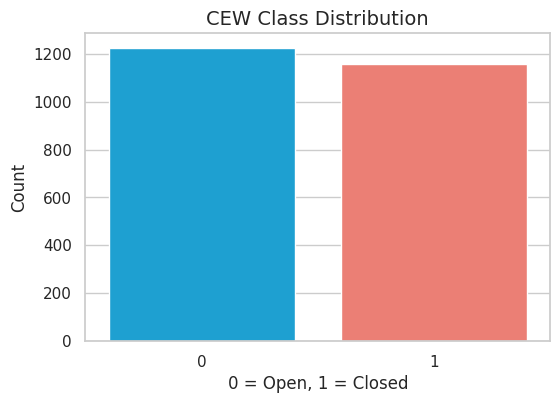

In [7]:
cew_rows = []
for label in ["open","closed"]:
    folder = CEW_DIR / label
    for img in folder.glob("*.jpg"):
        cew_rows.append({
            "path": str(img),
            "label": 0 if label=="open" else 1
        })

df_cew = pd.DataFrame(cew_rows)

plt.figure(figsize=(6,4))
sns.countplot(
    data=df_cew,
    x="label",
    palette=["#00AEEF", "#FF6F61"]
)
plt.title("CEW Class Distribution", fontsize=14)
plt.xlabel("0 = Open, 1 = Closed", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

## UTA EDA

/tmp/ipython-input-1575861578.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


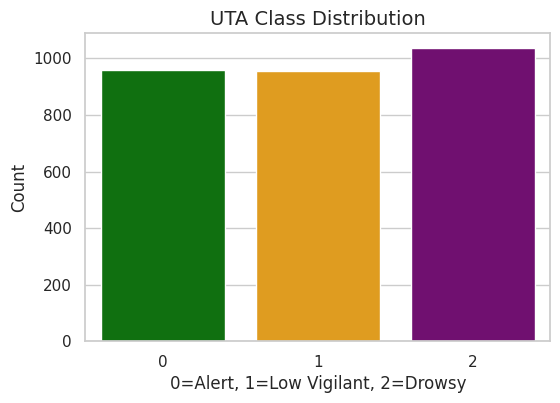

/tmp/ipython-input-1575861578.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


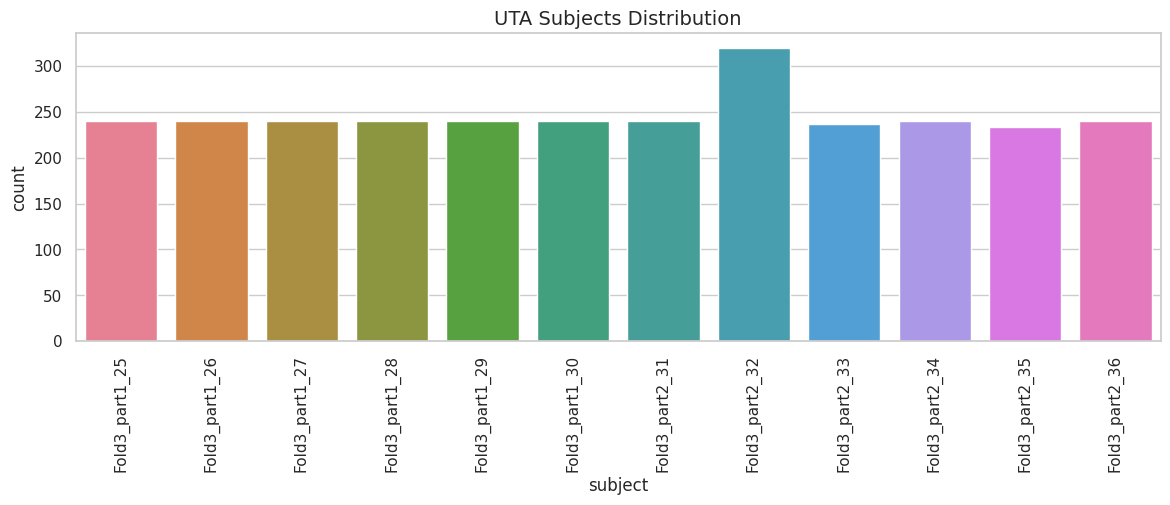

/tmp/ipython-input-1575861578.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


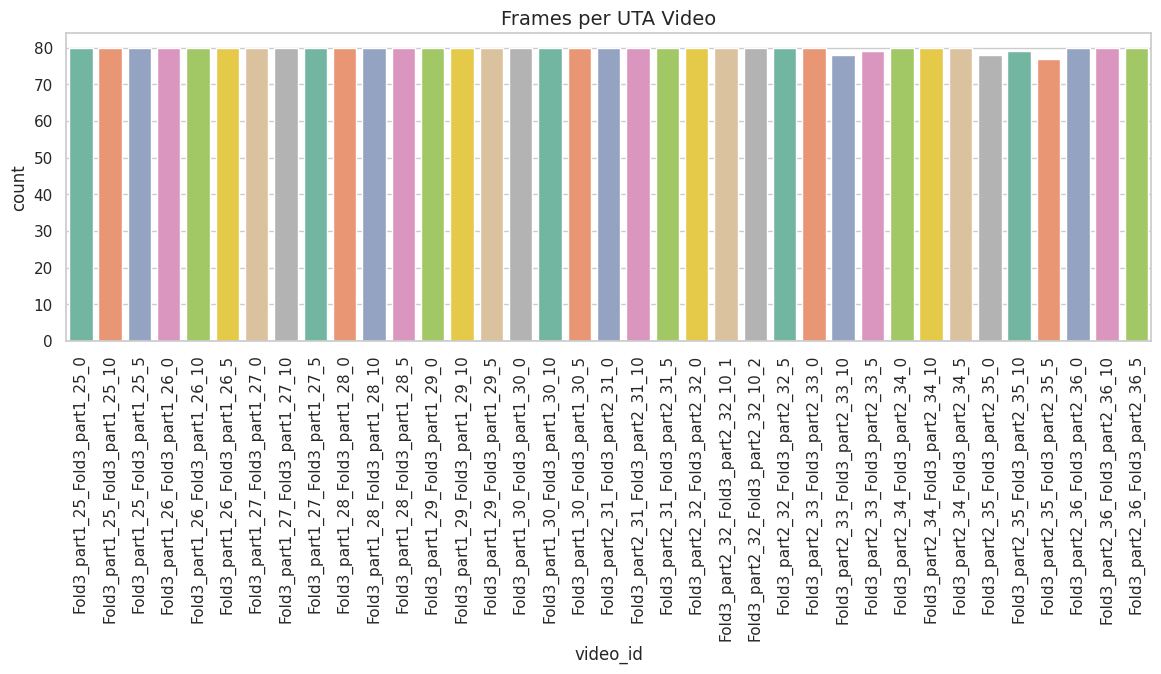

In [13]:
df_uta = pd.read_csv(UTA_CSV)

plt.figure(figsize=(6,4))
sns.countplot(
    data=df_uta,
    x="label",
    palette=["#008000", "#FFA500", "#800080"]
)
plt.title("UTA Class Distribution", fontsize=14)
plt.xlabel("0=Alert, 1=Low Vigilant, 2=Drowsy", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

plt.figure(figsize=(14,4))
sns.countplot(
    data=df_uta,
    x="subject",
    palette="husl"
)
plt.xticks(rotation=90)
plt.title("UTA Subjects Distribution", fontsize=14)
plt.show()
# Frames per video
df_uta["video_id"] = df_uta["subject"] + "_" + df_uta["video_id"]
plt.figure(figsize=(14,4))
sns.countplot(
    data=df_uta,
    x="video_id",
    palette="Set2"
)
plt.xticks(rotation=90)
plt.title("Frames per UTA Video", fontsize=14)
plt.show()

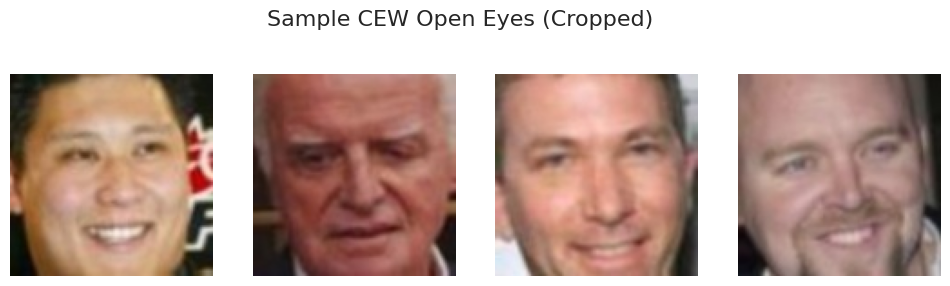

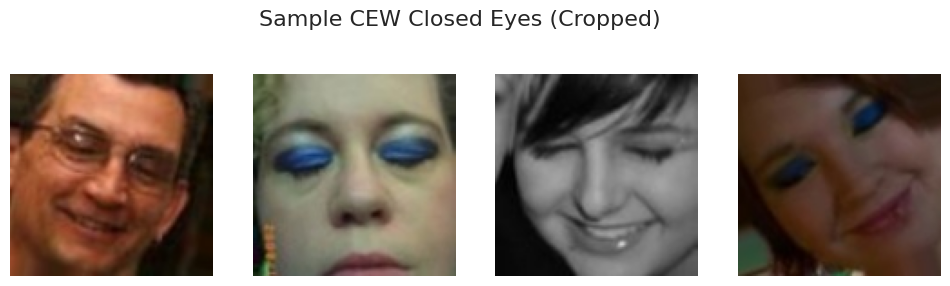

In [16]:
open_imgs = list((CEW_DIR/"open").glob("*.jpg"))
closed_imgs = list((CEW_DIR/"closed").glob("*.jpg"))

random_open = random.sample(open_imgs, 4)
random_closed = random.sample(closed_imgs, 4)

show_image_grid([str(p) for p in random_open], "Sample CEW Open Eyes (Cropped)")
show_image_grid([str(p) for p in random_closed], "Sample CEW Closed Eyes (Cropped)")

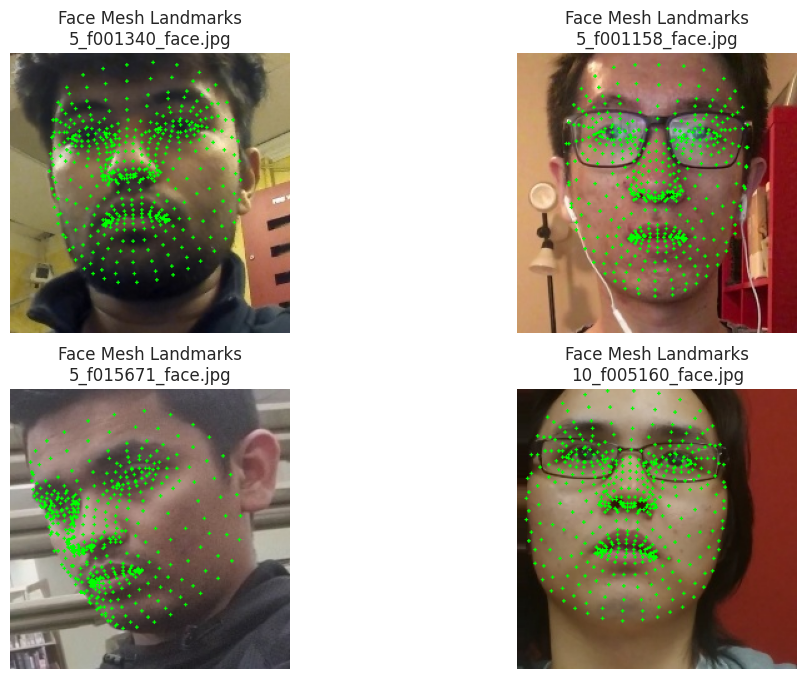

In [17]:
SAMPLE_UTA = Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224")
sample_list = list(SAMPLE_UTA.rglob("*.jpg"))
sample_images = random.sample(sample_list, 4)

mp_mesh = mp.solutions.face_mesh

plt.figure(figsize=(12,8))

with mp_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True) as fm:
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = fm.process(rgb)

        if res.multi_face_landmarks:
            lm = res.multi_face_landmarks[0]
            for p in lm.landmark:
                cx, cy = int(p.x * w), int(p.y * h)
                cv2.circle(rgb, (cx, cy), 1, (0,255,0), -1)

        plt.subplot(2,2,i+1)
        plt.imshow(rgb)
        plt.title(f"Face Mesh Landmarks\n{img_path.name}")
        plt.axis("off")

plt.show()

In [23]:
BASE_UTA = Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224")

candidate_folder = None
for sub in sorted(BASE_UTA.rglob("*")):
    if sub.is_dir():
        jpgs = list(sub.glob("*.jpg"))
        if len(jpgs) >= 30:
            candidate_folder = sub
            frame_paths = sorted(jpgs)
            break

print("Folder using for ear curve", candidate_folder)

Folder using for ear curve /content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224/Fold3_part1_25/0


Valid EAR frames: 40


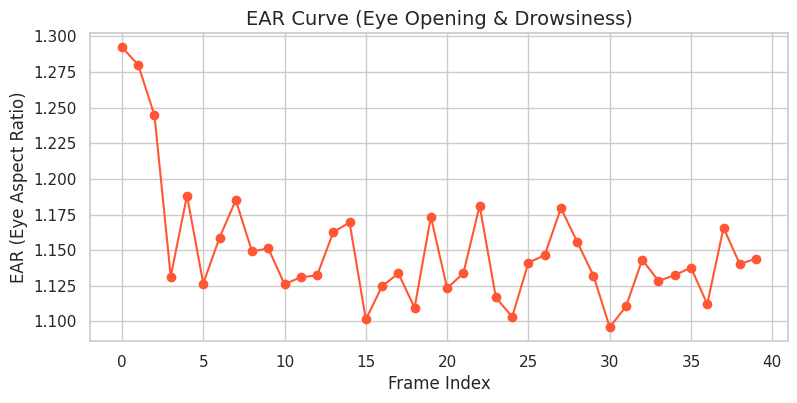

In [24]:
def EAR(eye):
    return (distance.euclidean(eye[1], eye[5]) +
            distance.euclidean(eye[2], eye[4])) / (2.0 * distance.euclidean(eye[0], eye[3]))

mp_mesh = mp.solutions.face_mesh
ears = []
frame_ids = []

with mp_mesh.FaceMesh(static_image_mode=True,
                      refine_landmarks=True,
                      max_num_faces=1) as fm:
    for idx, f in enumerate(frame_paths[:40]):
        img = cv2.imread(str(f))
        if img is None:
            continue
        h, w = img.shape[:2]
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = fm.process(rgb)

        if not res.multi_face_landmarks:
            continue

        lm = res.multi_face_landmarks[0]
        left_idx = [33, 133, 159, 145, 153, 144]
        eye = [(lm.landmark[i].x * w, lm.landmark[i].y * h) for i in left_idx]
        ear = EAR(eye)
        ears.append(ear)
        frame_ids.append(idx)

print("Valid EAR frames:", len(ears))

plt.figure(figsize=(9,4))
plt.plot(frame_ids, ears, marker="o", color="#FF5733")
plt.title("EAR Curve (Eye Opening & Drowsiness)", fontsize=14)
plt.xlabel("Frame Index")
plt.ylabel("EAR (Eye Aspect Ratio)")
plt.grid(True)
plt.show()

CEW Vs UTA Sample

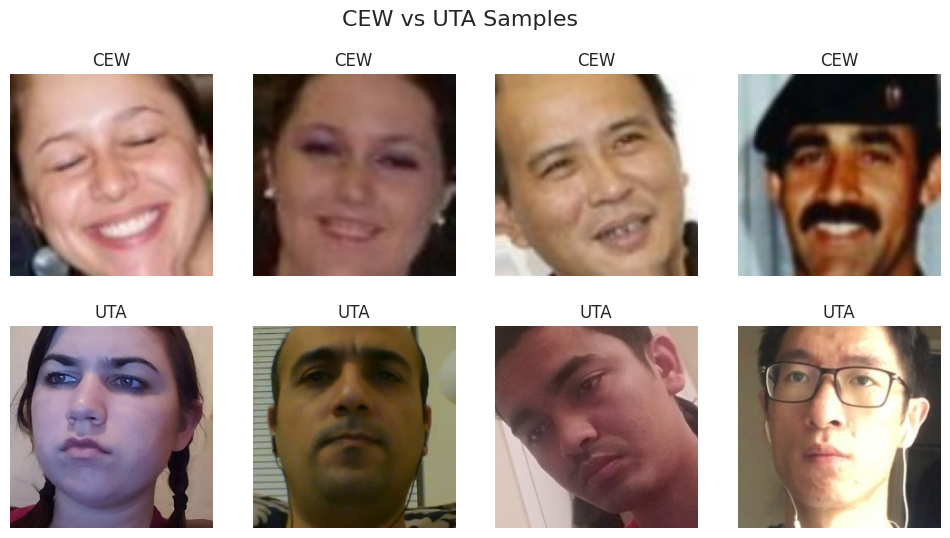

In [25]:
cew_samples = random.sample(list(Path("/content/drive/MyDrive/driver_drowsiness_detection/CEW_processed_112").rglob("*.jpg")), 4)
uta_samples = random.sample(list(Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224").rglob("*.jpg")), 4)

all_imgs = cew_samples + uta_samples

plt.figure(figsize=(12,6))
for i, p in enumerate(all_imgs):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    if i < 4:
        plt.title("CEW")
    else:
        plt.title("UTA")

plt.suptitle("CEW vs UTA Samples", fontsize=16)
plt.show()


  dataset  width  height
0     CEW    112     112
1     CEW    112     112
2     CEW    112     112
3     CEW    112     112
4     CEW    112     112


/tmp/ipython-input-3886356781.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_res, x="width", hue="dataset",


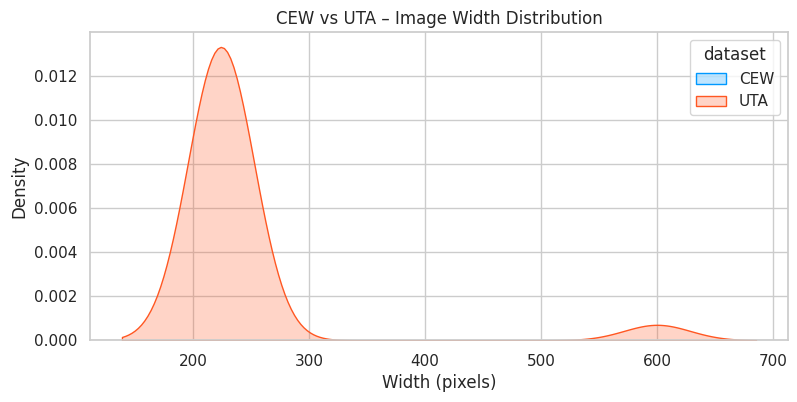

In [26]:
CEW_DIR = Path("/content/drive/MyDrive/driver_drowsiness_detection/CEW_processed_112")
UTA_DIR = Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224")

data = []
cew_paths = list(CEW_DIR.rglob("*.jpg"))[:200]
uta_paths = list(UTA_DIR.rglob("*.jpg"))[:200]

for p in cew_paths:
    img = cv2.imread(str(p))
    if img is None:
        continue
    h, w = img.shape[:2]
    data.append({"dataset": "CEW", "width": w, "height": h})

for p in uta_paths:
    img = cv2.imread(str(p))
    if img is None:
        continue
    h, w = img.shape[:2]
    data.append({"dataset": "UTA", "width": w, "height": h})

df_res = pd.DataFrame(data)
print(df_res.head())

plt.figure(figsize=(9,4))
sns.kdeplot(data=df_res, x="width", hue="dataset",
            fill=True, common_norm=False,
            palette={"CEW": "#0099FF", "UTA": "#FF5722"})
plt.title("CEW vs UTA – Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.show()

Collected samples per class: {0: 60, 1: 60, 2: 60}
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


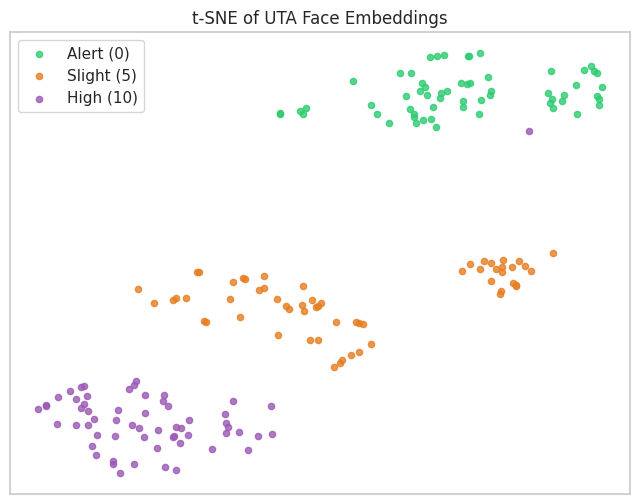

In [28]:
BASE_UTA = Path("/content/drive/MyDrive/driver_drowsiness_detection/UTA_face_crops_224")
samples = {0: [], 1: [], 2: []}
max_per_class = 60

for p in BASE_UTA.rglob("*.jpg"):
    stem = p.stem
    lbl = None
    if stem.startswith("0"):
        lbl = 0
    elif stem.startswith("5"):
        lbl = 1
    elif stem.startswith("10"):
        lbl = 2

    if lbl is not None and len(samples[lbl]) < max_per_class:
        samples[lbl].append(p)

    if all(len(samples[c]) >= max_per_class for c in [0,1,2]):
        break

sample_paths = []
sample_labels = []
for cls, lst in samples.items():
    for p in lst:
        sample_paths.append(p)
        sample_labels.append(cls)

print("Collected samples per class:",
      {c: len(samples[c]) for c in samples})

device = "cuda" if torch.cuda.is_available() else "cpu"
weights = models.ResNet18_Weights.IMAGENET1K_V1
backbone = models.resnet18(weights=weights)
backbone.fc = torch.nn.Identity()
backbone = backbone.to(device)
backbone.eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((112,112)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])

embeddings = []

with torch.no_grad():
    for p in sample_paths:
        img = cv2.imread(str(p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = transform(img).unsqueeze(0).to(device)
        emb = backbone(x).cpu().numpy().squeeze()
        embeddings.append(emb)

embeddings = np.vstack(embeddings)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
Z = tsne.fit_transform(embeddings)

palette = {0: "#2ecc71", 1: "#e67e22", 2: "#9b59b6"}
label_names = {0: "Alert (0)", 1: "Slight (5)", 2: "High (10)"}

plt.figure(figsize=(8,6))
for cls in [0,1,2]:
    idx = [i for i,l in enumerate(sample_labels) if l==cls]
    plt.scatter(Z[idx,0], Z[idx,1], s=20,
                c=palette[cls], label=label_names[cls], alpha=0.8)

plt.title("t-SNE of UTA Face Embeddings")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

## Train/Test/Val

## Loading CSV Files to train/test/val

In [5]:

BASE_ROOT = Path("/content/drive/MyDrive/driver_drowsiness_detection")

CEW_META_CSV = BASE_ROOT / "processed" / "cew_final_meta.csv"

print("CEW meta exists:", CEW_META_CSV.exists())

cew_head = pd.read_csv(CEW_META_CSV)
print("CEW shape:", cew_head.shape)

print("CEW columns:", cew_head.columns.tolist())
print("\nCEW label counts:\n", cew_head["label"].value_counts())

CEW meta exists: True
CEW shape: (2381, 4)
CEW columns: ['img_path', 'label', 'label_name', 'video_id']

CEW label counts:
 label
0    1224
1    1157
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
cew_train_df, cew_temp_df = train_test_split(
    cew_head,
    test_size=0.30,
    stratify=cew_head["label"],
    random_state=42,
)
cew_val_df, cew_test_df = train_test_split(
    cew_temp_df,
    test_size=0.50,
    stratify=cew_temp_df["label"],
    random_state=42,
)

In [8]:
print("CEW train/val/test sizes:", len(cew_train_df), len(cew_val_df), len(cew_test_df))
print("\nCEW train labels:\n", cew_train_df["label"].value_counts())
print("\nCEW val labels:\n", cew_val_df["label"].value_counts())
print("\nCEW test labels:\n", cew_test_df["label"].value_counts())

CEW train/val/test sizes: 1666 357 358

CEW train labels:
 label
0    856
1    810
Name: count, dtype: int64

CEW val labels:
 label
0    184
1    173
Name: count, dtype: int64

CEW test labels:
 label
0    184
1    174
Name: count, dtype: int64


## Class weights

In [9]:
cew_classes = np.sort(cew_train_df["label"].unique())
cew_cw = compute_class_weight(
    class_weight="balanced",
    classes=cew_classes,
    y=cew_train_df["label"].values
)
cew_class_weights = torch.tensor(cew_cw, dtype=torch.float32)
print("CEW class weights:", cew_class_weights)

CEW class weights: tensor([0.9731, 1.0284])


## Data Loaders

In [10]:
IMG_SIZE = 112
BATCH_SIZE = 64

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

class FaceDataset(Dataset):
    def __init__(self, df, img_col="img_path", label_col="label", transform=None):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row[self.img_col]
        label = int(row[self.label_col])

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label

In [11]:
cew_train_ds = FaceDataset(cew_train_df, transform=train_tf)
cew_val_ds   = FaceDataset(cew_val_df,   transform=val_tf)
cew_test_ds  = FaceDataset(cew_test_df,  transform=val_tf)

cew_train_loader = DataLoader(cew_train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
cew_val_loader   = DataLoader(cew_val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
cew_test_loader  = DataLoader(cew_test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Dataloaders ready for CEW.")

Dataloaders ready for CEW.


In [12]:
cew_batch_imgs, cew_batch_labels = next(iter(cew_train_loader))
print("CEW batch:", cew_batch_imgs.shape, cew_batch_labels.shape)

CEW batch: torch.Size([64, 3, 112, 112]) torch.Size([64])


## Training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def build_cew_mobilenet():
    weights = MobileNet_V2_Weights.IMAGENET1K_V1
    model = mobilenet_v2(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 2)
    return model.to(device)

model = build_cew_mobilenet()

best_lr = 5e-4
criterion = nn.CrossEntropyLoss(weight=cew_class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

Using device: cuda


In [14]:
def run_one_epoch(model, loader, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    epoch_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            logits = model(imgs)
            loss = criterion(logits, labels)

            if optimizer is not None:
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * imgs.size(0)

        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.detach().cpu().numpy())
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = epoch_loss / len(loader.dataset)
    acc = (all_preds == all_labels).mean()
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = np.nan

    return avg_loss, acc, macro_f1, macro_rec, auc

In [16]:
max_epochs = 20
patience = 5

best_val_f1 = 0.0
best_state = None
epochs_no_improve = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_f1": [],
    "val_f1": [],
    "val_auc": []
}

print("\n Training CEW MobileNetV2")

for epoch in range(1, max_epochs + 1):
    tr_loss, tr_acc, tr_f1, tr_rec, tr_auc = run_one_epoch(
        model, cew_train_loader, criterion, optimizer
    )
    val_loss, val_acc, val_f1, val_rec, val_auc = run_one_epoch(
        model, cew_val_loader, criterion, optimizer=None
    )

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_f1"].append(tr_f1)
    history["val_f1"].append(val_f1)
    history["val_auc"].append(val_auc)

    print(f"Epoch {epoch:02d}/{max_epochs} | "
          f"Train F1={tr_f1:.3f}, Val F1={val_f1:.3f}, "
          f"Val Recall={val_rec:.3f}, Val AUC={val_auc:.3f}")

    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

if best_state is not None:
    model.load_state_dict(best_state)


 Training CEW MobileNetV2
Epoch 01/20 | Train F1=0.859, Val F1=0.950, Val Recall=0.950, Val AUC=0.993
Epoch 02/20 | Train F1=0.956, Val F1=0.975, Val Recall=0.975, Val AUC=0.997
Epoch 03/20 | Train F1=0.948, Val F1=0.966, Val Recall=0.966, Val AUC=0.995
Epoch 04/20 | Train F1=0.981, Val F1=0.980, Val Recall=0.981, Val AUC=0.998
Epoch 05/20 | Train F1=0.981, Val F1=0.980, Val Recall=0.980, Val AUC=0.998
Epoch 06/20 | Train F1=0.979, Val F1=0.969, Val Recall=0.969, Val AUC=0.999
Epoch 07/20 | Train F1=0.953, Val F1=0.972, Val Recall=0.972, Val AUC=0.998
Epoch 08/20 | Train F1=0.984, Val F1=0.975, Val Recall=0.975, Val AUC=0.998
Epoch 09/20 | Train F1=0.983, Val F1=0.972, Val Recall=0.972, Val AUC=0.998
Early stopping at epoch 9 (no improvement for 5 epochs).


In [17]:
BASE_ROOT = Path("/content/drive/MyDrive/driver_drowsiness_detection")
save_dir = BASE_ROOT / "training_outputs"
save_dir.mkdir(parents=True, exist_ok=True)
cew_mnet_path = save_dir / "cew_mobilenetv2_best.pth"
torch.save(model.state_dict(), cew_mnet_path)
print("Saved best CEW MobileNetV2 to:", cew_mnet_path)

Saved best CEW MobileNetV2 to: /content/drive/MyDrive/driver_drowsiness_detection/training_outputs/cew_mobilenetv2_best.pth


## Metrics

In [18]:
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in cew_test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc = (all_preds == all_labels).mean()
test_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
test_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
test_auc = roc_auc_score(all_labels, all_probs)

In [19]:
print("CEW MobileNetV2")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro F1: {test_f1:.4f}")
print(f"Macro Recall: {test_rec:.4f}")
print(f"AUC: {test_auc:.4f}")

CEW MobileNetV2
Accuracy: 0.9832
Macro F1: 0.9832
Macro Recall: 0.9835
AUC: 0.9993


In [20]:
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=["Open (0)", "Closed (1)"]))


Classification report:
              precision    recall  f1-score   support

    Open (0)       0.99      0.97      0.98       184
  Closed (1)       0.97      0.99      0.98       174

    accuracy                           0.98       358
   macro avg       0.98      0.98      0.98       358
weighted avg       0.98      0.98      0.98       358



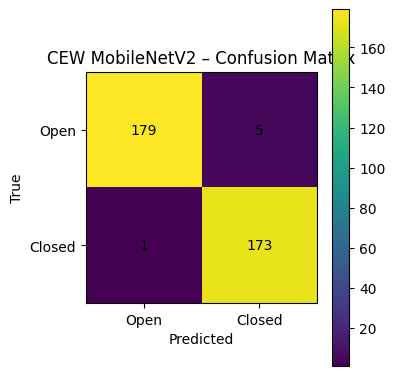

In [21]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title("CEW MobileNetV2 – Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Open", "Closed"])
plt.yticks([0,1], ["Open", "Closed"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Plots for Model-01 MobileNetV2

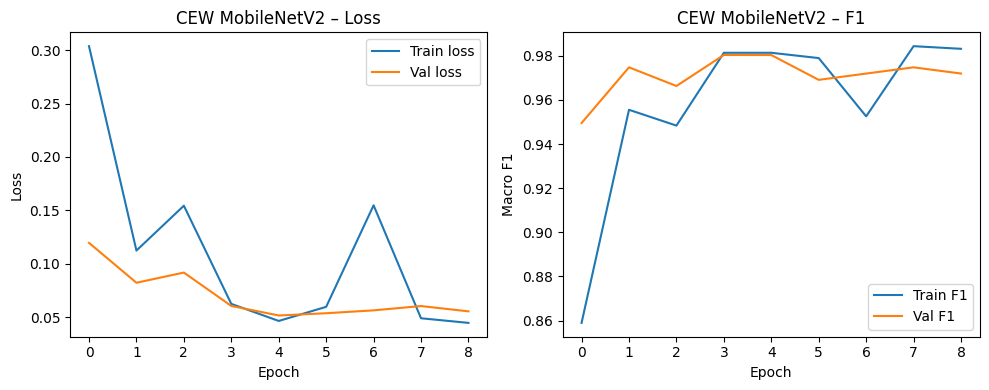

In [22]:
epochs_ran = len(history["train_loss"])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CEW MobileNetV2 – Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_f1"], label="Train F1")
plt.plot(history["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.title("CEW MobileNetV2 – F1")
plt.legend()

plt.tight_layout()
plt.show()

## CEW Model 02

## Resnet18

In [15]:
def train_cew_model(model, model_name, train_loader, val_loader,
                    class_weights, max_epochs=25, patience=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_f1 = 0.0
    best_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_f1": [],
        "val_f1": [],
        "val_auc": []
    }

    print(f"\n Training {model_name} on CEW...")

    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc, tr_f1, tr_rec, tr_auc = run_one_epoch(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc, val_f1, val_rec, val_auc = run_one_epoch(
            model, val_loader, criterion, optimizer=None
        )

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["train_f1"].append(tr_f1)
        history["val_f1"].append(val_f1)
        history["val_auc"].append(val_auc)

        print(f"[{model_name}] Epoch {epoch:02d}/{max_epochs} | "
              f"Train F1={tr_f1:.3f}, Val F1={val_f1:.3f}, "
              f"Val Recall={val_rec:.3f}, Val AUC={val_auc:.3f}")

        if val_f1 > best_val_f1 + 1e-4:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f" [{model_name}] Early stopping at epoch {epoch}.")
                break

    model.load_state_dict(best_state)
    return model, history

In [16]:
def evaluate_cew_on_test(model, test_loader, model_name ="CEW model"):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = (all_preds == all_labels).mean()
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n {model_name} – CEW TEST METRICS")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Macro Recall: {macro_rec:.4f}")
    print(f"AUC: {auc:.4f}")

    print("\nClassification report:")
    print(classification_report(all_labels, all_preds, target_names=["Open (0)", "Closed (1)"]))

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(f"{model_name} – Confusion Matrix (CEW)")
    plt.colorbar()
    plt.xticks([0,1], ["Open", "Closed"])
    plt.yticks([0,1], ["Open", "Closed"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "acc": acc,
        "macro_f1": macro_f1,
        "macro_rec": macro_rec,
        "auc": auc
    }

In [17]:
from torchvision.models import resnet18, ResNet18_Weights

def build_cew_resnet18():
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, 2)   # open / closed
    return model.to(device)

resnet_model = build_cew_resnet18()
resnet_model, resnet_history = train_cew_model(
    model=resnet_model,
    model_name="CEW_ResNet18",
    train_loader=cew_train_loader,
    val_loader=cew_val_loader,
    class_weights=cew_class_weights,
    max_epochs=25,
    patience=5,
    lr=1e-4
)


 Training CEW_ResNet18 on CEW...
[CEW_ResNet18] Epoch 01/25 | Train F1=0.824, Val F1=0.944, Val Recall=0.944, Val AUC=0.990
[CEW_ResNet18] Epoch 02/25 | Train F1=0.956, Val F1=0.969, Val Recall=0.969, Val AUC=0.996
[CEW_ResNet18] Epoch 03/25 | Train F1=0.977, Val F1=0.972, Val Recall=0.971, Val AUC=0.997
[CEW_ResNet18] Epoch 04/25 | Train F1=0.979, Val F1=0.966, Val Recall=0.967, Val AUC=0.997
[CEW_ResNet18] Epoch 05/25 | Train F1=0.969, Val F1=0.936, Val Recall=0.937, Val AUC=0.996
[CEW_ResNet18] Epoch 06/25 | Train F1=0.981, Val F1=0.972, Val Recall=0.972, Val AUC=0.998
[CEW_ResNet18] Epoch 07/25 | Train F1=0.986, Val F1=0.975, Val Recall=0.975, Val AUC=0.999
[CEW_ResNet18] Epoch 08/25 | Train F1=0.983, Val F1=0.936, Val Recall=0.937, Val AUC=0.997
[CEW_ResNet18] Epoch 09/25 | Train F1=0.973, Val F1=0.975, Val Recall=0.975, Val AUC=0.996
[CEW_ResNet18] Epoch 10/25 | Train F1=0.968, Val F1=0.961, Val Recall=0.962, Val AUC=0.997
[CEW_ResNet18] Epoch 11/25 | Train F1=0.989, Val F1=0.96

Saved CEW ResNet18 model to: /content/drive/MyDrive/driver_drowsiness_detection/training_outputs/cew_resnet18_best.pth

 CEW ResNet18 – CEW TEST METRICS
Accuracy: 0.9832
Macro F1: 0.9832
Macro Recall: 0.9837
AUC: 0.9992

Classification report:
              precision    recall  f1-score   support

    Open (0)       1.00      0.97      0.98       184
  Closed (1)       0.97      1.00      0.98       174

    accuracy                           0.98       358
   macro avg       0.98      0.98      0.98       358
weighted avg       0.98      0.98      0.98       358



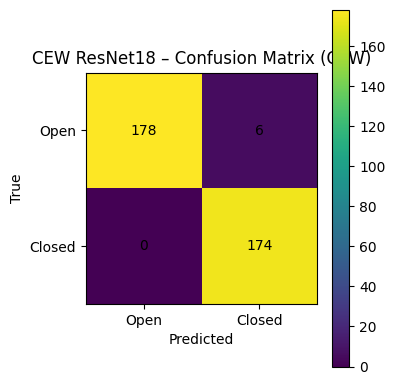

In [18]:
BASE_ROOT = Path("/content/drive/MyDrive/driver_drowsiness_detection")
cew_out_dir = BASE_ROOT / "training_outputs"
cew_out_dir.mkdir(parents=True, exist_ok=True)

resnet_path = cew_out_dir / "cew_resnet18_best.pth"
torch.save(resnet_model.state_dict(), resnet_path)
print("Saved CEW ResNet18 model to:", resnet_path)

resnet_test_metrics = evaluate_cew_on_test(
    resnet_model, cew_test_loader, model_name="CEW ResNet18"
)

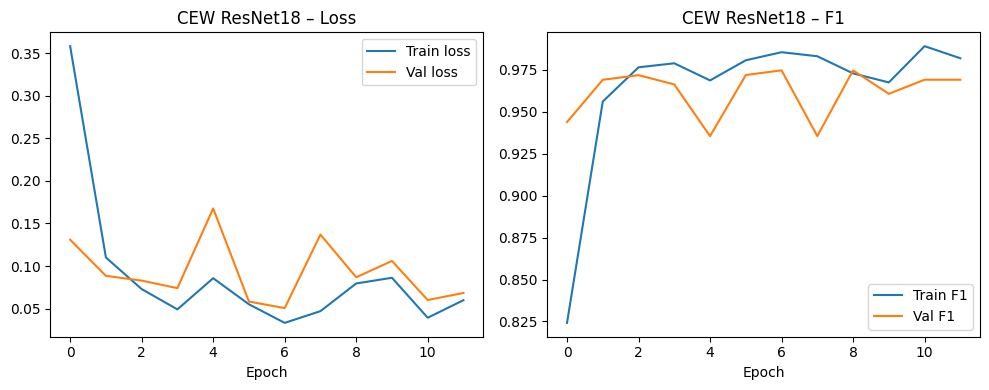

In [19]:
epochs_ran = len(resnet_history["train_loss"])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(resnet_history["train_loss"], label="Train loss")
plt.plot(resnet_history["val_loss"], label="Val loss")
plt.title("CEW ResNet18 – Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(resnet_history["train_f1"], label="Train F1")
plt.plot(resnet_history["val_f1"], label="Val F1")
plt.title("CEW ResNet18 – F1")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

## Model 3 Simple CNN

In [20]:
class SimpleCEWCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 14 * 14, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def build_cew_simple_cnn():
    model = SimpleCEWCNN(num_classes=2)
    return model.to(device)

simple_cnn = build_cew_simple_cnn()

In [21]:
simple_cnn, simple_history = train_cew_model(
    model=simple_cnn,
    model_name="CEW_SimpleCNN",
    train_loader=cew_train_loader,
    val_loader=cew_val_loader,
    class_weights=cew_class_weights,
    max_epochs=30,
    patience=6,
    lr=1e-3
)


 Training CEW_SimpleCNN on CEW...
[CEW_SimpleCNN] Epoch 01/30 | Train F1=0.564, Val F1=0.568, Val Recall=0.612, Val AUC=0.782
[CEW_SimpleCNN] Epoch 02/30 | Train F1=0.591, Val F1=0.612, Val Recall=0.643, Val AUC=0.812
[CEW_SimpleCNN] Epoch 03/30 | Train F1=0.654, Val F1=0.742, Val Recall=0.743, Val AUC=0.812
[CEW_SimpleCNN] Epoch 04/30 | Train F1=0.695, Val F1=0.736, Val Recall=0.738, Val AUC=0.831
[CEW_SimpleCNN] Epoch 05/30 | Train F1=0.716, Val F1=0.657, Val Recall=0.675, Val AUC=0.858
[CEW_SimpleCNN] Epoch 06/30 | Train F1=0.724, Val F1=0.776, Val Recall=0.777, Val AUC=0.861
[CEW_SimpleCNN] Epoch 07/30 | Train F1=0.706, Val F1=0.766, Val Recall=0.767, Val AUC=0.863
[CEW_SimpleCNN] Epoch 08/30 | Train F1=0.735, Val F1=0.784, Val Recall=0.786, Val AUC=0.882
[CEW_SimpleCNN] Epoch 09/30 | Train F1=0.756, Val F1=0.725, Val Recall=0.731, Val AUC=0.873
[CEW_SimpleCNN] Epoch 10/30 | Train F1=0.768, Val F1=0.815, Val Recall=0.816, Val AUC=0.889
[CEW_SimpleCNN] Epoch 11/30 | Train F1=0.779,

Saved CEW Simple CNN to: /content/drive/MyDrive/driver_drowsiness_detection/training_outputs/cew_simple_cnn_best.pth

 CEW Simple CNN – CEW TEST METRICS
Accuracy: 0.9078
Macro F1: 0.9078
Macro Recall: 0.9089
AUC: 0.9747

Classification report:
              precision    recall  f1-score   support

    Open (0)       0.95      0.87      0.91       184
  Closed (1)       0.87      0.95      0.91       174

    accuracy                           0.91       358
   macro avg       0.91      0.91      0.91       358
weighted avg       0.91      0.91      0.91       358



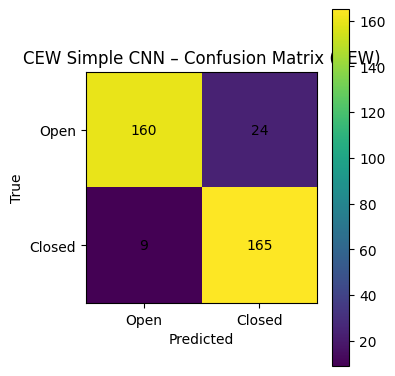

In [22]:
simple_path = cew_out_dir / "cew_simple_cnn_best.pth"
torch.save(simple_cnn.state_dict(), simple_path)
print("Saved CEW Simple CNN to:", simple_path)

simple_test_metrics = evaluate_cew_on_test(
    simple_cnn, cew_test_loader, model_name="CEW Simple CNN"
)

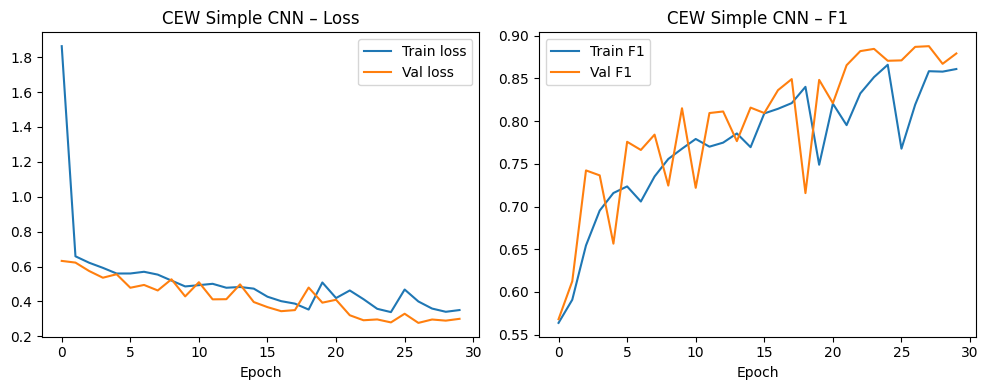

In [23]:
epochs_ran = len(simple_history["train_loss"])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(simple_history["train_loss"], label="Train loss")
plt.plot(simple_history["val_loss"], label="Val loss")
plt.title("CEW Simple CNN – Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(simple_history["train_f1"], label="Train F1")
plt.plot(simple_history["val_f1"], label="Val F1")
plt.title("CEW Simple CNN – F1")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

## UTA TRAINING

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled pr

In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix
)

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_ROOT = Path("/content/drive/MyDrive/driver_drowsiness_detection")
PROCESSED = BASE_ROOT / "processed"

#load metadata, split, sequences, dataloaders, class weights

In [6]:
UTA_META_CSV = PROCESSED / "uta_final_meta.csv"
print("UTA meta exists:", UTA_META_CSV.exists())

uta_face = pd.read_csv(UTA_META_CSV)
print("UTA columns:", uta_face.columns.tolist())
print(uta_face.head())

for col in ["img_path", "label", "frame_idx", "video_id"]:
    if col not in uta_face.columns:
        raise ValueError(f"Column '{col}' missing from uta_final_meta.csv")

uta_face["label"] = uta_face["label"].astype(int)

UTA meta exists: True
UTA columns: ['img_path', 'label', 'label_name', 'subject', 'intensity_folder', 'frame_idx', 'video_id']
                                            img_path  label label_name  \
0  /content/drive/MyDrive/driver_drowsiness_detec...      0      alert   
1  /content/drive/MyDrive/driver_drowsiness_detec...      0      alert   
2  /content/drive/MyDrive/driver_drowsiness_detec...      0      alert   
3  /content/drive/MyDrive/driver_drowsiness_detec...      0      alert   
4  /content/drive/MyDrive/driver_drowsiness_detec...      0      alert   

          subject intensity_folder  frame_idx          video_id  
0  Fold3_part1_25                0        222  Fold3_part1_25_0  
1  Fold3_part1_25                0        444  Fold3_part1_25_0  
2  Fold3_part1_25                0        666  Fold3_part1_25_0  
3  Fold3_part1_25                0        888  Fold3_part1_25_0  
4  Fold3_part1_25                0       1110  Fold3_part1_25_0  


In [7]:
def make_abs_uta(p):
    p = str(p)
    if p.startswith("/content/"):
        return p
    return str(BASE_ROOT / p)

uta_face["img_path"] = uta_face["img_path"].apply(make_abs_uta)

print("\n UTA frame-level label counts:")
print(uta_face["label"].value_counts().sort_index())

#for leakage
video_rows = uta_face[["video_id", "label"]].drop_duplicates()
print("\nUTA video-level label counts:")
print(video_rows["label"].value_counts().sort_index())
print("Total unique videos:", len(video_rows))

vid_train, vid_temp = train_test_split(
    video_rows,
    test_size=0.30,
    stratify=video_rows["label"],
    random_state=SEED,
)

vid_val, vid_test = train_test_split(
    vid_temp,
    test_size=0.50,            # 15% / 15%
    stratify=vid_temp["label"],
    random_state=SEED,
)

def subset_by_video(df, vids):
    return df[df["video_id"].isin(vids["video_id"])].reset_index(drop=True)

uta_train_df = subset_by_video(uta_face, vid_train)
uta_val_df   = subset_by_video(uta_face, vid_val)
uta_test_df  = subset_by_video(uta_face, vid_test)

print("\nUTA frames per split:")
for name, df in [("TRAIN", uta_train_df), ("VAL", uta_val_df), ("TEST", uta_test_df)]:
    print(f"{name}: {len(df)}")
    print(df["label"].value_counts().sort_index())
    print("------")

print("\nLeakage check")
print("train ∩ val:", set(uta_train_df["video_id"]) & set(uta_val_df["video_id"]))
print("train ∩ test:", set(uta_train_df["video_id"]) & set(uta_test_df["video_id"]))
print("val ∩ test:", set(uta_val_df["video_id"]) & set(uta_test_df["video_id"]))


 UTA frame-level label counts:
label
0     958
1     956
2    1037
Name: count, dtype: int64

UTA video-level label counts:
label
0    12
1    12
2    13
Name: count, dtype: int64
Total unique videos: 37

UTA frames per split:
TRAIN: 1994
label
0    638
1    636
2    720
Name: count, dtype: int64
------
VAL: 478
label
0    160
1    160
2    158
Name: count, dtype: int64
------
TEST: 479
label
0    160
1    160
2    159
Name: count, dtype: int64
------

Leakage check
train ∩ val: set()
train ∩ test: set()
val ∩ test: set()


# sequences

In [8]:
SEQ_LEN   = 16   # frames per sequence
IMG_SIZE  = 112  # 112x112
BATCH_SEQ = 8

def build_uta_sequences(df, seq_len=16):
    sequences = []
    for vid, g in df.groupby("video_id"):
        g = g.copy().sort_values("frame_idx")

        paths = g["img_path"].tolist()
        label = int(g["label"].mode()[0])

        if len(paths) < seq_len:
            continue

        for start in range(0, len(paths) - seq_len + 1, seq_len):
            seq_paths = paths[start:start+seq_len]
            sequences.append({
                "video_id": vid,
                "frames": seq_paths,
                "label": label
            })
    return sequences

uta_train_seqs = build_uta_sequences(uta_train_df, seq_len=SEQ_LEN)
uta_val_seqs   = build_uta_sequences(uta_val_df,   seq_len=SEQ_LEN)
uta_test_seqs  = build_uta_sequences(uta_test_df,  seq_len=SEQ_LEN)

print(f"\nUTA sequences train: {len(uta_train_seqs)}, val: {len(uta_val_seqs)}, test: {len(uta_test_seqs)}")


UTA sequences train: 122, val: 29, test: 29


# transforms

In [9]:
from torchvision import transforms

uta_seq_train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

uta_seq_eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# dataloaders
class UTASeqDataset(Dataset):
    def __init__(self, sequences, transform):
        self.sequences = sequences
        self.transform = transform

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_info = self.sequences[idx]
        paths = seq_info["frames"]
        label = int(seq_info["label"])

        frames = []
        for fp in paths:
            img = Image.open(fp).convert("RGB")
            img = self.transform(img)
            frames.append(img)
        frames = torch.stack(frames, dim=0)
        return frames, label

uta_train_seq_ds = UTASeqDataset(uta_train_seqs, uta_seq_train_tf)
uta_val_seq_ds   = UTASeqDataset(uta_val_seqs,   uta_seq_eval_tf)
uta_test_seq_ds  = UTASeqDataset(uta_test_seqs,  uta_seq_eval_tf)

uta_train_seq_loader = DataLoader(uta_train_seq_ds, batch_size=BATCH_SEQ, shuffle=True,  num_workers=0)
uta_val_seq_loader   = DataLoader(uta_val_seq_ds,   batch_size=BATCH_SEQ, shuffle=False, num_workers=0)
uta_test_seq_loader  = DataLoader(uta_test_seq_ds,  batch_size=BATCH_SEQ, shuffle=False, num_workers=0)

x_batch, y_batch = next(iter(uta_train_seq_loader))
print("Example batch seq shape:", x_batch.shape)
print("Example batch labels shape:", y_batch.shape)

Example batch seq shape: torch.Size([8, 16, 3, 112, 112])
Example batch labels shape: torch.Size([8])


# class weights

In [10]:
uta_classes = np.sort(uta_train_df["label"].unique())
uta_cw = compute_class_weight(
    class_weight="balanced",
    classes=uta_classes,
    y=uta_train_df["label"].values
)
uta_class_weights = torch.tensor(uta_cw, dtype=torch.float32).to(device)
NUM_UTA_CLASSES = len(uta_classes)

print("\n UTA class weights:", uta_class_weights, "| class order:", uta_classes)


 UTA class weights: tensor([1.0418, 1.0451, 0.9231], device='cuda:0') | class order: [0 1 2]


# Train/eval for sequence models

In [11]:
def run_one_epoch_seq(model, loader, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    epoch_loss = 0.0
    all_preds, all_labels = [], []
    all_probs = []

    for seqs, labels in loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            logits = model(seqs)
            loss = criterion(logits, labels)
            if optimizer is not None:
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * seqs.size(0)

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.append(probs.detach().cpu().numpy())
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = epoch_loss / len(loader.dataset)
    acc = (all_preds == all_labels).mean()
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class="ovo")
    except ValueError:
        auc = np.nan

    return avg_loss, acc, macro_f1, macro_rec, auc

# UTA – CNN–LSTM model

In [12]:
class CNNLSTMUTA(nn.Module):
    def __init__(
        self,
        num_classes=3,
        hidden_size=256,
        num_layers=1,
        bidirectional=True,
        dropout=0.5,
        freeze_backbone=True
    ):
        super().__init__()
        weights = MobileNet_V2_Weights.IMAGENET1K_V1
        backbone = mobilenet_v2(weights=weights)

        self.backbone_features = backbone.features
        self.backbone_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.backbone_feat_dim = backbone.last_channel

        if freeze_backbone:
            for p in self.backbone_features.parameters():
                p.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=self.backbone_feat_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        lstm_out_dim = hidden_size * (2 if bidirectional else 1)

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_out_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)

        feat = self.backbone_features(x)
        feat = self.backbone_pool(feat)
        feat = feat.view(B, T, self.backbone_feat_dim)

        lstm_out, _ = self.lstm(feat)
        seq_feat = lstm_out.mean(dim=1)

        logits = self.fc(seq_feat)
        return logits

#  Optuna hyperparameter tuning for CNN–LSTM (UTA)

In [14]:
def run_one_epoch_uta_seq(model, loader, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    epoch_loss = 0.0
    all_preds, all_labels = [], []
    all_probs = []

    for seqs, labels in loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            logits = model(seqs)
            loss = criterion(logits, labels)
            if optimizer is not None:
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * seqs.size(0)

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.append(probs.detach().cpu().numpy())
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = epoch_loss / len(loader.dataset)
    acc = (all_preds == all_labels).mean()
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class="ovo")
    except ValueError:
        auc = np.nan

    return avg_loss, acc, macro_f1, macro_rec, auc

def build_uta_cnn_lstm_model(hidden_size, num_layers, bidirectional, dropout):
    model = CNNLSTMUTA(
        num_classes=len(uta_class_weights),
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout
    ).to(device)
    return model

def uta_lstm_objective(trial):
    # hyperparameters to search
    hidden_size  = trial.suggest_categorical("hidden_size", [128, 256, 384])
    lr           = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    num_layers   = trial.suggest_int("num_layers", 1, 2)
    bidirectional= trial.suggest_categorical("bidirectional", [True, False])
    dropout      = trial.suggest_float("dropout", 0.3, 0.6)

    model = build_uta_cnn_lstm_model(
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout
    )

    criterion = nn.CrossEntropyLoss(weight=uta_class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    max_epochs_per_trial = 5

    best_val_f1 = 0.0

    for epoch in range(1, max_epochs_per_trial + 1):
        tr_loss, tr_acc, tr_f1, tr_rec, tr_auc = run_one_epoch_uta_seq(
            model, uta_train_seq_loader, criterion, optimizer
        )
        val_loss, val_acc, val_f1, val_rec, val_auc = run_one_epoch_uta_seq(
            model, uta_val_seq_loader, criterion, optimizer=None
        )

        trial.report(val_f1, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

    return best_val_f1

study = optuna.create_study(direction="maximize")
print(" Starting Optuna tuning for CNN–LSTM (UTA)...")

study.optimize(uta_lstm_objective, n_trials=5)

print("\n Optuna tuning finished.")
print("Best trial:")
best_trial = study.best_trial
print("  Value (best val F1):", best_trial.value)
print("  Params:")
for k, v in best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-12-05 02:03:40,600] A new study created in memory with name: no-name-d35f6974-259c-4fcc-9782-892ae9c0d7cf


 Starting Optuna tuning for CNN–LSTM (UTA)...


[I 2025-12-05 02:11:39,719] Trial 0 finished with value: 0.17094017094017092 and parameters: {'hidden_size': 256, 'lr': 0.00017148476332541407, 'num_layers': 2, 'bidirectional': False, 'dropout': 0.5785955259246532}. Best is trial 0 with value: 0.17094017094017092.
[I 2025-12-05 02:12:38,240] Trial 1 finished with value: 0.26143790849673204 and parameters: {'hidden_size': 256, 'lr': 0.00047884013281230647, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.4464202041405654}. Best is trial 1 with value: 0.26143790849673204.
[I 2025-12-05 02:13:35,778] Trial 2 finished with value: 0.17094017094017092 and parameters: {'hidden_size': 384, 'lr': 0.0005561642652189495, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.35116181396561724}. Best is trial 1 with value: 0.26143790849673204.
[I 2025-12-05 02:14:33,229] Trial 3 finished with value: 0.28461152882205515 and parameters: {'hidden_size': 128, 'lr': 0.00071693799334596, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.5617775962


 Optuna tuning finished.
Best trial:
  Value (best val F1): 0.28461152882205515
  Params:
    hidden_size: 128
    lr: 0.00071693799334596
    num_layers: 1
    bidirectional: True
    dropout: 0.5617775962894089


# Train best CNN–LSTM with tuned hyperparameters

Best Optuna params: {'hidden_size': 128, 'lr': 0.00071693799334596, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.5617775962894089}

 Training FINAL UTA CNN–LSTM model
Epoch 01/20 | Train F1=0.348, Val F1=0.111, Val Recall=0.185, Val AUC=0.342
Epoch 02/20 | Train F1=0.339, Val F1=0.176, Val Recall=0.333, Val AUC=0.265
Epoch 03/20 | Train F1=0.555, Val F1=0.066, Val Recall=0.070, Val AUC=0.359
Epoch 04/20 | Train F1=0.521, Val F1=0.147, Val Recall=0.141, Val AUC=0.293
Epoch 05/20 | Train F1=0.487, Val F1=0.065, Val Recall=0.070, Val AUC=0.225
Epoch 06/20 | Train F1=0.523, Val F1=0.148, Val Recall=0.144, Val AUC=0.226
Epoch 07/20 | Train F1=0.598, Val F1=0.367, Val Recall=0.389, Val AUC=0.328
Epoch 08/20 | Train F1=0.672, Val F1=0.198, Val Recall=0.219, Val AUC=0.279
Epoch 09/20 | Train F1=0.670, Val F1=0.173, Val Recall=0.259, Val AUC=0.340
Epoch 10/20 | Train F1=0.749, Val F1=0.315, Val Recall=0.363, Val AUC=0.396
Epoch 11/20 | Train F1=0.774, Val F1=0.121, Val Recall=0.107, Val

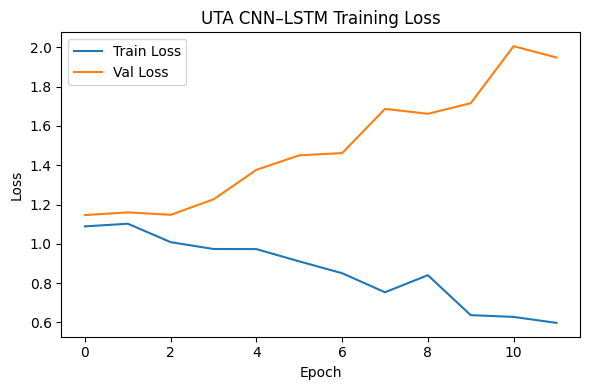

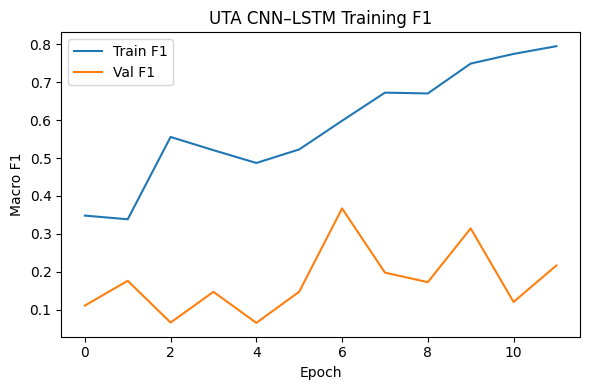

In [16]:
best_trial = study.best_trial
best_params = best_trial.params
print("Best Optuna params:", best_params)
hidden_size   = best_params["hidden_size"]
lr            = best_params["lr"]
num_layers    = best_params["num_layers"]
bidirectional = best_params["bidirectional"]
dropout       = best_params["dropout"]

# final model
uta_final_model = CNNLSTMUTA(
    num_classes=len(uta_class_weights),
    hidden_size=hidden_size,
    num_layers=num_layers,
    bidirectional=bidirectional,
    dropout=dropout
).to(device)

criterion = nn.CrossEntropyLoss(weight=uta_class_weights)
optimizer = torch.optim.Adam(uta_final_model.parameters(), lr=lr)

# Training config
max_epochs = 20
patience   = 5
best_val_f1 = 0.0
epochs_no_improve = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_f1": [],
    "val_f1": [],
    "val_auc": []
}

print("\n Training FINAL UTA CNN–LSTM model")

best_state = copy.deepcopy(uta_final_model.state_dict())

for epoch in range(1, max_epochs + 1):
    tr_loss, tr_acc, tr_f1, tr_rec, tr_auc = run_one_epoch_uta_seq(
        uta_final_model, uta_train_seq_loader, criterion, optimizer
    )
    val_loss, val_acc, val_f1, val_rec, val_auc = run_one_epoch_uta_seq(
        uta_final_model, uta_val_seq_loader, criterion, optimizer=None
    )

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_f1"].append(tr_f1)
    history["val_f1"].append(val_f1)
    history["val_auc"].append(val_auc)

    print(f"Epoch {epoch:02d}/{max_epochs} | "
          f"Train F1={tr_f1:.3f}, Val F1={val_f1:.3f}, "
          f"Val Recall={val_rec:.3f}, Val AUC={val_auc:.3f}")

    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        best_state = copy.deepcopy(uta_final_model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(" Early stp")
            break

# Load best weights
uta_final_model.load_state_dict(best_state)

# Plot training curves
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("UTA CNN–LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_f1"], label="Train F1")
plt.plot(history["val_f1"], label="Val F1")
plt.title("UTA CNN–LSTM Training F1")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.legend()
plt.tight_layout()
plt.show()


 FINAL UTA CNN–LSTM – TEST METRICS
Accuracy: 0.3448
Macro F1: 0.1802
Macro Recall: 0.3333
AUC (OVO): 0.4635

Classification report:
                  precision    recall  f1-score   support

       Alert (0)       0.37      1.00      0.54        10
Low Vigilant (1)       0.00      0.00      0.00        10
      Drowsy (2)       0.00      0.00      0.00         9

        accuracy                           0.34        29
       macro avg       0.12      0.33      0.18        29
    weighted avg       0.13      0.34      0.19        29


Confusion matrix:
 [[10  0  0]
 [ 8  0  2]
 [ 9  0  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


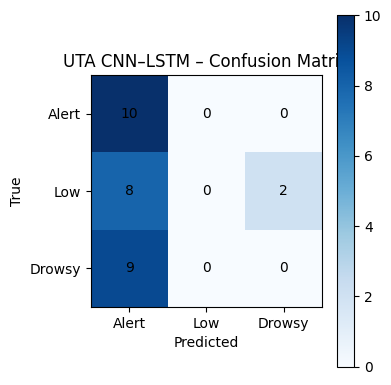

In [18]:
#evaluation
uta_final_model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for seqs, labels in uta_test_seq_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        logits = uta_final_model(seqs)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc = (all_preds == all_labels).mean()
test_f1  = f1_score(all_labels, all_preds, average="macro", zero_division=0)
test_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
try:
    test_auc = roc_auc_score(all_labels, all_probs, multi_class="ovo")
except ValueError:
    test_auc = np.nan

print("\n FINAL UTA CNN–LSTM – TEST METRICS")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro F1: {test_f1:.4f}")
print(f"Macro Recall: {test_rec:.4f}")
print(f"AUC (OVO): {test_auc:.4f}")

print("\nClassification report:")
print(classification_report(
    all_labels, all_preds,
    target_names=["Alert (0)", "Low Vigilant (1)", "Drowsy (2)"]
))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion matrix:\n", cm)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("UTA CNN–LSTM – Confusion Matrix")
plt.colorbar()
plt.xticks([0,1,2], ["Alert","Low","Drowsy"])
plt.yticks([0,1,2], ["Alert","Low","Drowsy"])
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# CNN + Transformer model (UTA)

In [19]:
class CNNTransformerUTA(nn.Module):
    def __init__(
        self,
        num_classes=3,
        d_model=256,
        nhead=4,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.2,
        freeze_backbone=True
    ):
        super().__init__()

        weights = MobileNet_V2_Weights.IMAGENET1K_V1
        backbone = mobilenet_v2(weights=weights)
        self.backbone_features = backbone.features
        self.backbone_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.backbone_feat_dim = backbone.last_channel  # 1280

        if freeze_backbone:
            for p in self.backbone_features.parameters():
                p.requires_grad = False

        self.feat_proj = nn.Linear(self.backbone_feat_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)

        feat = self.backbone_features(x)
        feat = self.backbone_pool(feat)
        feat = feat.view(B, T, self.backbone_feat_dim)

        feat = self.feat_proj(feat)
        feat = feat.permute(1, 0, 2)

        trans_out = self.transformer(feat)
        seq_feat = trans_out.mean(dim=0)

        seq_feat = self.dropout(seq_feat)
        logits = self.fc(seq_feat)
        return logits

uta_transformer = CNNTransformerUTA(
    num_classes=NUM_UTA_CLASSES,
    d_model=256,
    nhead=4,
    num_layers=2,
    dim_feedforward=512,
    dropout=0.2,
    freeze_backbone=True
).to(device)

print(uta_transformer)

CNNTransformerUTA(
  (backbone_features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Batch

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Train & evaluate UTA CNN+Transformer


 Training UTA CNN+Transformer.
Epoch 01/20 | Train F1=0.259 | Val F1=0.158 | Val Recall=0.333 | Val AUC=0.418
Epoch 02/20 | Train F1=0.357 | Val F1=0.171 | Val Recall=0.333 | Val AUC=0.263
Epoch 03/20 | Train F1=0.239 | Val F1=0.171 | Val Recall=0.333 | Val AUC=0.279
Epoch 04/20 | Train F1=0.278 | Val F1=0.158 | Val Recall=0.333 | Val AUC=0.337
Epoch 05/20 | Train F1=0.309 | Val F1=0.171 | Val Recall=0.333 | Val AUC=0.217
Epoch 06/20 | Train F1=0.288 | Val F1=0.144 | Val Recall=0.267 | Val AUC=0.232
Epoch 07/20 | Train F1=0.324 | Val F1=0.162 | Val Recall=0.200 | Val AUC=0.243
Early stopping.

 UTA CNN+Transformer metrics
Accuracy: 0.3448
Macro F1: 0.1709
Macro Recall: 0.3333
AUC (OVO): 0.6728

 Classification report:
                  precision    recall  f1-score   support

       Alert (0)       0.34      1.00      0.51        10
Low Vigilant (1)       0.00      0.00      0.00        10
      Drowsy (2)       0.00      0.00      0.00         9

        accuracy                     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


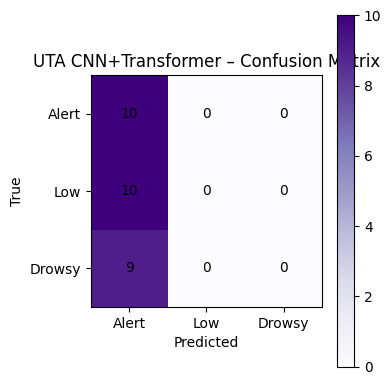

In [20]:
criterion_t = nn.CrossEntropyLoss(weight=uta_class_weights)
optimizer_t = torch.optim.Adam(uta_transformer.parameters(), lr=1e-3)

max_epochs = 20
patience   = 5
best_val_f1 = 0.0
best_state = copy.deepcopy(uta_transformer.state_dict())
epochs_no_improve = 0

history_tr = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": [], "val_auc": []}

print("\n Training UTA CNN+Transformer.")

for epoch in range(1, max_epochs + 1):
    tr_loss, tr_acc, tr_f1, tr_rec, tr_auc = run_one_epoch_seq(
        uta_transformer, uta_train_seq_loader, criterion_t, optimizer_t
    )
    val_loss, val_acc, val_f1, val_rec, val_auc = run_one_epoch_seq(
        uta_transformer, uta_val_seq_loader, criterion_t, optimizer=None
    )

    history_tr["train_loss"].append(tr_loss)
    history_tr["val_loss"].append(val_loss)
    history_tr["train_f1"].append(tr_f1)
    history_tr["val_f1"].append(val_f1)
    history_tr["val_auc"].append(val_auc)

    print(
        f"Epoch {epoch:02d}/{max_epochs} | "
        f"Train F1={tr_f1:.3f} | Val F1={val_f1:.3f} | "
        f"Val Recall={val_rec:.3f} | Val AUC={val_auc:.3f}"
    )

    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        best_state = copy.deepcopy(uta_transformer.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break

uta_transformer.load_state_dict(best_state)

# evalution
uta_transformer.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for seqs, labels in uta_test_seq_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)
        logits = uta_transformer(seqs)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc = (all_preds == all_labels).mean()
test_f1  = f1_score(all_labels, all_preds, average="macro", zero_division=0)
test_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
try:
    test_auc = roc_auc_score(all_labels, all_probs, multi_class="ovo")
except ValueError:
    test_auc = np.nan

print("\n UTA CNN+Transformer metrics")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro F1: {test_f1:.4f}")
print(f"Macro Recall: {test_rec:.4f}")
print(f"AUC (OVO): {test_auc:.4f}")

print("\n Classification report:")
print(classification_report(
    all_labels, all_preds,
    target_names=["Alert (0)", "Low Vigilant (1)", "Drowsy (2)"]
))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Purples")
plt.title("UTA CNN+Transformer – Confusion Matrix")
plt.colorbar()
plt.xticks([0,1,2], ["Alert","Low","Drowsy"])
plt.yticks([0,1,2], ["Alert","Low","Drowsy"])
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()